In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [2]:
import pandas as pd
import numpy as np
from statsmodels.graphics import tsaplots
from statsmodels.stats import diagnostic
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import scipy

from load_dataset import Dataset
import plotting

In [3]:
dataset = Dataset('../data/dataset/')

In [ ]:
# Возьмем временной ряд.

In [4]:
ts = dataset['international-airline-passengers.csv']

In [ ]:
# нарисуем. Видим ярко выраженную сезонность (мб не одну?), гетероскедастичность и тренд.

<AxesSubplot:xlabel='1949-01'>

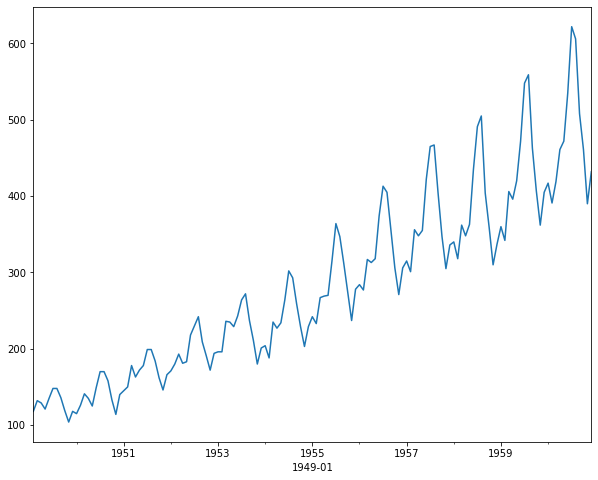

In [5]:
ts.plot(figsize=(10, 8))

In [ ]:
# Посммотрим график автокорреляций - видим тренд и сильную цикличную автокореляцию

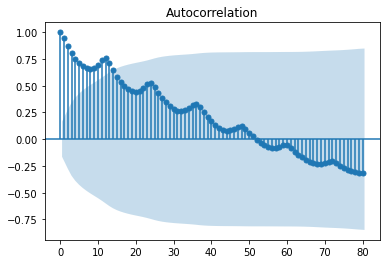

In [10]:
tsaplots.plot_acf(ts, lags=80);

In [ ]:
# проверим автокорреляция при помощи теса Ланга-Бокса

In [11]:
_, p_value = diagnostic.acorr_ljungbox(ts)

D:\Anaconda3\envs\ts_summer\lib\site-packages\statsmodels\stats\diagnostic.py:533: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)
D:\Anaconda3\envs\ts_summer\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [12]:
# видим, что значения p-value сильно ниже порога (обычно 0.05, 0.01), значит мы смело отвергаем нулевую гипотезу
# то есть данные явно не случайны
max(p_value), min(p_value)

(2.265296147964726e-30, 0.0)

In [13]:
# проверим ряд на стационарость критерием Дики-Фуллера
# видим, что p-value сильно выше порога, значит мы никак не можем отвергнуть нулевую гипотезу, следовательно -
# ряд не стационарен
p_value = adfuller(ts)[1]
p_value

0.9915115096288659

In [14]:
# Попробуем сделать его стационарным
# Для начала постараемся избавиться от гетероскедастичности, взяв логарифм
ts_log = np.log(ts)

<AxesSubplot:xlabel='1949-01'>

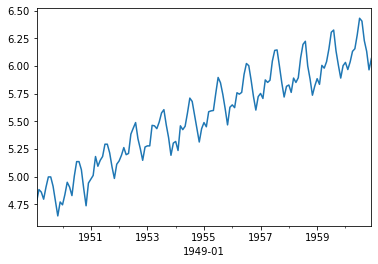

In [15]:
ts_log.plot()
# отлично, на вид, гетероскедастичность ушла

In [16]:
# впрочем, наши статистические тесты остались этим неудовлетворены и снова показывают крайнюю нестационарность
# скоррелированность
_, p_value = diagnostic.acorr_ljungbox(ts_log)
print(min(p_value), max(p_value))
print(adfuller(ts)[1])

0.0 9.436327894354704e-31
0.9915115096288659
D:\Anaconda3\envs\ts_summer\lib\site-packages\statsmodels\stats\diagnostic.py:533: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)
D:\Anaconda3\envs\ts_summer\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [17]:
# чтож, попробуем применить дифференцирование
ts_diff = ts_log.diff()

In [18]:
plotting.plot_ts(ts_log, ts_diff)

Loading BokehJS ...

In [19]:
_, p_value = diagnostic.acorr_ljungbox(ts_diff.dropna(), lags=70)
print(min(p_value), max(p_value))
print(adfuller(ts_diff.dropna())[1])

4.037713402960903e-107 0.021048164264366388
0.04803397252875413
D:\Anaconda3\envs\ts_summer\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='1949-01'>

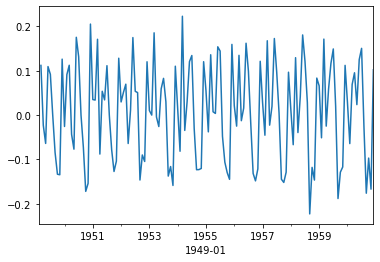

In [20]:
ts_diff.plot()

In [ ]:
# кхмм, опять не помогает, давайте посмотрим на график автокорреляций и увидим, что период сезонности 
# приходится на 12 лаг, попробуем сезонное дифференцирование

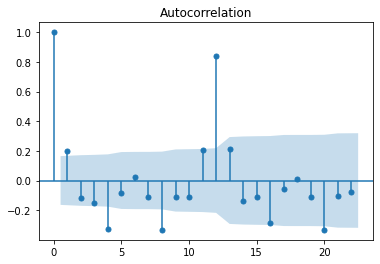

In [21]:
tsaplots.plot_acf(ts_diff.dropna());

In [22]:
ts_season_diff = ts_diff.diff(12)

In [23]:
_, p_value = diagnostic.acorr_ljungbox(ts_season_diff.dropna(), lags=45)
print(min(p_value), max(p_value))
print(adfuller(ts_season_diff.dropna())[1])

6.188062493682463e-07 0.0025904863525081454
0.00016009049261960238
D:\Anaconda3\envs\ts_summer\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='1949-01'>

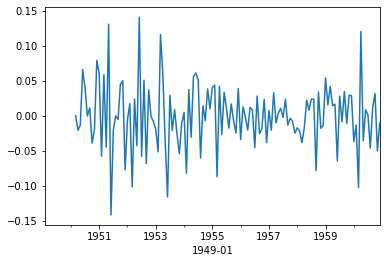

In [24]:
ts_season_diff.plot()

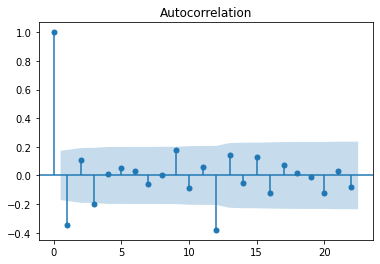

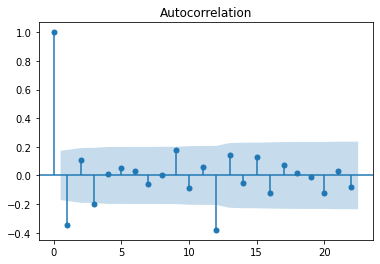

In [25]:
tsaplots.plot_acf(ts_season_diff.dropna())

In [ ]:
# Бонус - пример простого обратно трансформирования ряда. По сути, к ряду просто применяются обратные операторы.
# exp для log, кумулятивная сумма для дифференцирования

In [ ]:
ts = dataset['hour_3553.csv']

In [ ]:
ts.plot()

In [ ]:
transformed = np.log(ts).diff()

In [ ]:
transformed.plot()

In [ ]:
back_transformed = np.exp(transformed.cumsum())

In [ ]:
back_transformed.plot()

## Задание:
    1. Выбрать несколько временных рядов.
    2. Используя вышеперечисленные преобразования, добиться стационарности ряда.
    3. Критерием стационарности будет служить значение p-value теста Дики-Фуллера, меньшее 0.05 и соответствующий график автокорреляции.

In [26]:
ts = dataset['stl_example.csv']

<AxesSubplot:>

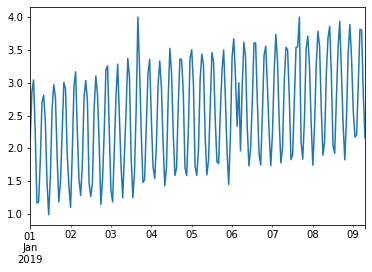

In [27]:
ts.plot()

In [28]:
plotting.plot_ts(ts)

Loading BokehJS ...

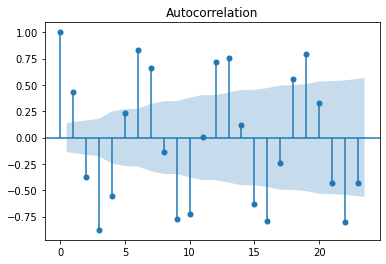

In [29]:
tsaplots.plot_acf(ts.diff().dropna());

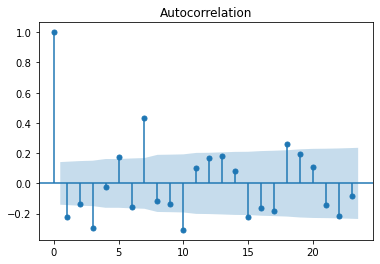

In [30]:
tsaplots.plot_acf(ts.diff().diff(6).dropna());

<AxesSubplot:>

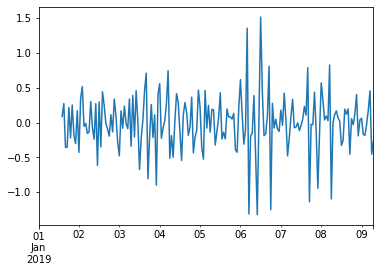

In [31]:
ts.diff().diff(6).diff(7).plot()

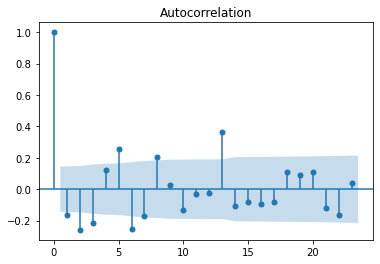

In [32]:
tsaplots.plot_acf(ts.diff().diff(6).diff(7).dropna());

In [34]:
adfuller(ts.diff().diff(6).diff(7).dropna())

(-9.28418234174832,
 1.2280720735424048e-15,
 11,
 174,
 {'1%': -3.4685016947910636,
  '5%': -2.8782983668563396,
  '10%': -2.57570415906989},
 81.61901215507936)

In [37]:
import pandas_datareader as web
_df = web.DataReader('SBER', data_source='moex', start='1999-01-01', end='2021-05-24')
data = _df[_df['BOARDID'] == 'TQBR'].filter(['CLOSE', 'VALUE', 'VOLUME']).dropna()
data.to_csv('sbrf.csv')

In [43]:
data = pd.read_csv('sbrf.csv')

In [44]:
data.head()

,TRADEDATE,CLOSE,VALUE,VOLUME
0,2013-03-25,98.79,59340002.8,593680.0
1,2013-03-26,97.20,126030358.8,1283550.0
2,2013-03-27,96.75,121835900.2,1261950.0
3,2013-03-28,98.59,192469794.9,1971410.0
4,2013-03-29,98.76,77268860.1,782000.0
